In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import argparse
from collections import OrderedDict

import yaml
import csv
import time
from datetime import datetime
import shutil
import logging
from typing import Tuple, Sequence, Any, Union
from functools import partial

from jax import random
import jax.numpy as jnp
import jax
from brax.io import html
from brax import jumpy as jp
from brax import envs
from IPython.display import HTML

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import evojax
from evojax.util import get_params_format_fn
from evojax.task.base import TaskState
from evojax.policy.base import PolicyState
from evojax.policy.base import PolicyNetwork
from flax.struct import dataclass
from flax import linen as nn

from evojax.task.brax_task import BraxTask
from evojax.task.gym_task import Gym
from evojax.algo import PGPE, OpenES
from evojax import ObsNormalizer
from evojax import SimManager

sns.set_style('white')
sns.set_palette('muted', desat=.6)
sns.set_context("notebook", font_scale=1.0,
                rc={"lines.linewidth": 2.5})

root_dir = '/home/floyed/Metaplasticity__Unifying_Learning_and_Homeostatic_Plasticity_in_Spiking_Neural_Networks'
output_dir = '/home/floyed/evojax/examples/metaplasticity_plot'

In [10]:
def load_model(model_dir: str, fname='best.npz') -> Tuple[np.ndarray, np.ndarray, int, float, int]:
    model_file = os.path.join(model_dir, fname)
    if not os.path.exists(model_file):
        raise ValueError('Model file {} does not exist.')
    with np.load(model_file, allow_pickle=True) as data:
        params = data['params']
        obs_params = data['obs_params']
        epoch = data.get('epoch', 0)
        score = data.get('score', -float('Inf'))
        steps = data.get('steps', 0)
    return params, obs_params, epoch, score, steps

In [11]:
def eval_with_injury(policy, env_name, obs_normalizer, params, obs_params, target=None, injury=False, plot=True, seed=42, injury_ratio=0., ctrl=None):

    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # max_steps=len(ctrl) if ctrl else 1000
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    rng = jax.random.PRNGKey(seed + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)


    step = 0
    while not task_state.done and step < len(ctrl):
    # while step < len(ctrl) if ctrl else 1000:
        if ctrl:
            task_state = task_state.replace(
                obs=task_state.obs.at[-1].set(ctrl[step]))
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        rollout.append(task_state)
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.

        if injury_ratio != 0:
            num_zeros = int(injury_ratio * np.prod(policy_state.fast_Ws[1].shape))
            # random_indices = np.random.choice(policy_state.fast_Ws[1].shape[0], num_zeros, replace=False)
            tmp = np.array(policy_state.fast_Ws[1])
            random_indices = np.random.choice(tmp.size, num_zeros, replace=False)
            tmp.flat[random_indices] *= 0
            policy_state.fast_Ws[1] = jnp.array(tmp)

        if step > 500 and step < 550 and injury:
            policy_state.fast_Ws[1] *= 0

        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = step_fn(task_state, act[0])
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws') and step % 10 == 0:
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    if plot:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = np.array(jnp.concatenate(w)[jnp.newaxis, :, jnp.newaxis, :, :])
            # TODO: w

        html.save_html(os.path.join(output_dir, 'eval_with_injury_{}.html'.format(target)), env.sys, [s.qp for s in rollout])

        fig, ax = plt.subplots()
        ax.plot(rewards)
        plt.savefig(os.path.join(output_dir, 'BraxMetaLearning_{}.pdf').format(target))

    return rewards, rollout

In [12]:
def plot_dt(lr, A, B, C, D, tau_pre=1./np.e, tau_post=1./np.e, vis=False):
    a = A
    b = - A * C
    c = B
    d = D
    x = np.arange(-10, 10, 1e-2)
    x_neg = x[:x.shape[0] // 2]
    x_pos = x[x.shape[0] // 2:]

    dw_neg = lr * (b * np.exp(tau_pre * x_neg) + d)
    dw_pos = lr * ((a + c) * np.exp(-tau_post * x_pos) + d)
    dw = np.concatenate([dw_neg, dw_pos])

    if vis:
        plt.plot(x, dw)
    # plt.fill_betweenx(dw_neg, x_neg, color='r')
    # plt.fill_betweenx(dw_pos, x_pos, color='b')
    # plt.show()
    return x, dw

In [14]:
env = 'ant_dir'  # ur5e  fetch  swimmer_dir  halfcheetah_vel  ant_dir
num_tasks = 8
hidden_dims = [128]
resume = f'{root_dir}/checkpoints/RL_exp/ant_dir/'

train_task = BraxTask(
    env_name=env,
    test=False,
    num_tasks=num_tasks
    # terminate_when_unhealthy=args.terminate_when_unhealthy
)
policy = getattr(evojax.policy, 'MetaStdpMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

# obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

(28,) (8,)


In [15]:
# j, k = 6, 6
def read(j, k):
    df = pd.DataFrame(columns=['Generation', 'Plasticity\nAttribute', 'Value', 'i', 'o'], index=[0, 1, 2])
    vals = []

    for i in range(1, 151):
        best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume, fname='iter_{}.npz'.format(i * 10))
        first, second = policy._format_params_fn(best_params[None, :])
        lr, a, b, c, d = second
        # for j in range(lr.shape[1]):
        #     for k in range(lr.shape[2]):
        df.loc[len(df.index)] = [i * 10, 'lr', float(lr[0, j, k]), j, k]
        df.loc[len(df.index)] = [i * 10, 'A', float(a[0, j, k]), j, k]
        df.loc[len(df.index)] = [i * 10, 'B', float(b[0, j, k]), j, k]
        df.loc[len(df.index)] = [i * 10, 'C', float(c[0, j, k]), j, k]
        df.loc[len(df.index)] = [i * 10, 'D', float(d[0, j, k]), j, k]
        vals.append([lr[0, j, k], a[0, j, k], b[0, j, k], c[0, j, k], d[0, j, k]])
        #     break
        # break
    return df, vals

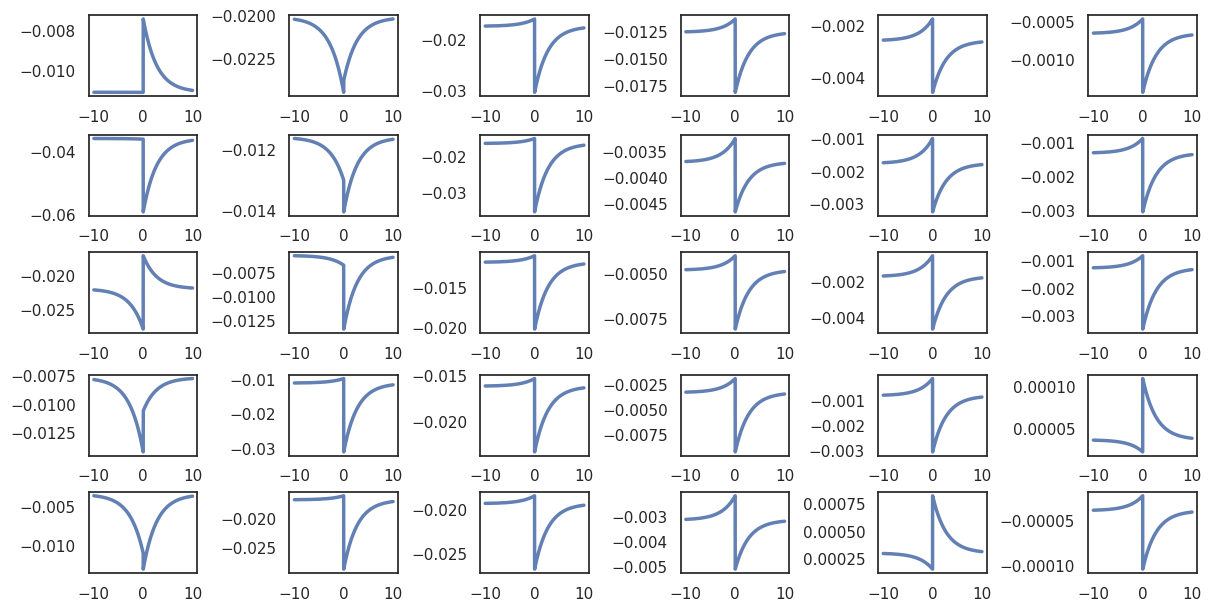

In [17]:
# for j in range(20):
df, vals = read(4, 0)
fig = plt.figure(figsize=(12, 6), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=5, ncols=6, figure=fig)  #, width_ratios=[.2, 1, 1, 1, 1, .08, 1.6], height_ratios=[0.02, 1, 1, 0.01])
for i in range(30):
    ax = fig.add_subplot(spec[i % 5, i // 5])
    plot_dt(*vals[i * 5], vis=True)
plt.show()

In [18]:
dws = []
for val in vals:
    x, dw = plot_dt(*val)
    dws.append(dw)
dws = np.array(dws)
_max = dws.max()
_min = dws.min()
dws[dws > 0] *= .5 * abs(_min) / _max

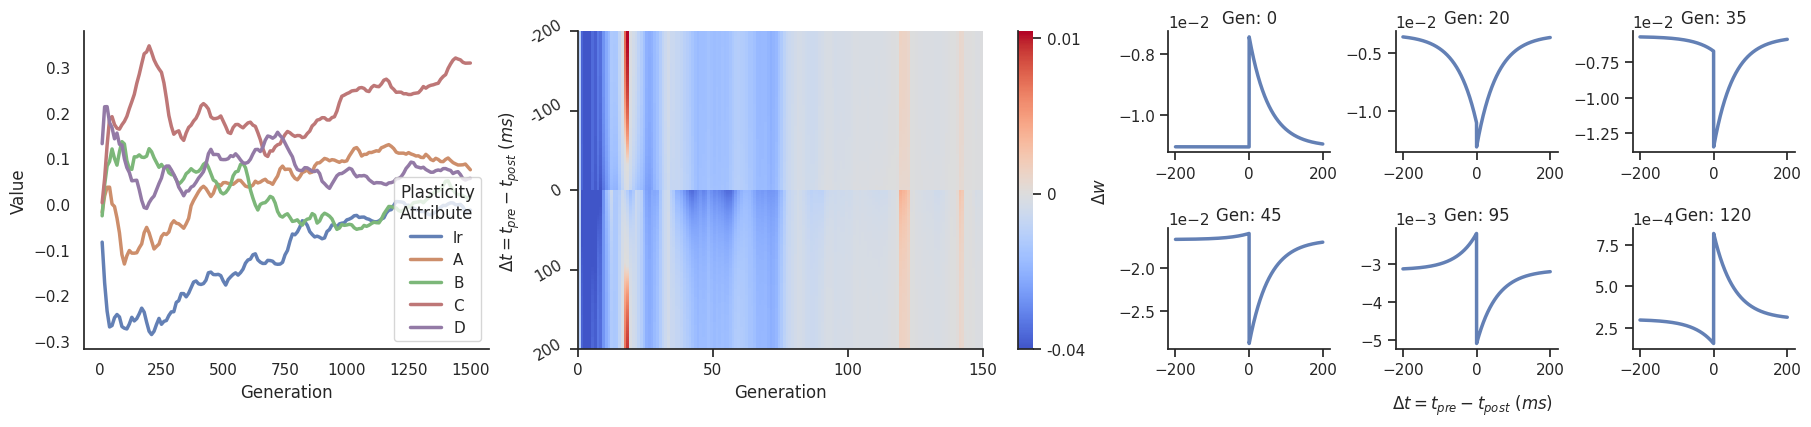

In [19]:
fig = plt.figure(figsize=(18, 4), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=2, ncols=5, figure=fig, width_ratios=[2, 2, 0.8, 0.8, 0.8])  #, width_ratios=[.2, 1, 1, 1, 1, .08, 1.6], height_ratios=[0.02, 1, 1, 0.01])

ax = fig.add_subplot(spec[:, 0])
sns.lineplot(data=df, x='Generation', y='Value', hue='Plasticity\nAttribute')
sns.set_style("ticks")
sns.despine()
# ax.set_xticks([0, 50, 100, 150], ['0', '50', '100', '150'], rotation = 30)
ax.set_xlabel('Generation')
#
#
ax = fig.add_subplot(spec[:, 1])
sns.heatmap(dws.transpose(), center=0., vmin=-0.04, ax=ax, cmap=plt.cm.coolwarm)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.04, 0, 0.04])
cbar.set_ticklabels(['-0.04', '0', '0.01'])
cbar.set_label('$\Delta w$')
ax.set_xticks([0, 50, 100, 150], ['0', '50', '100', '150'], rotation = 0)
ax.set_yticks([0, 500, 1000, 1500, 2000], ['-200', '-100', '0', '100', '200'], rotation = 30)
ax.set_xlabel('Generation')
ax.set_ylabel('$\Delta t = t_{pre} - t_{post} \\ (ms)$')
plt.savefig(os.path.join(output_dir, 'plasticity_heatmap_vis.pdf'), format='pdf', bbox_inches='tight')


indices = [0, 20, 35, 45, 95, 120]
# indices = [0, 20, 95, 120]

for i in range(6):
    r = i // 3
    c = i % 3 + 2
    ax = fig.add_subplot(spec[r, c])
    x, dw = plot_dt(*vals[indices[i]])
    ax.plot(x * 20, dw)
    sns.set_style("ticks")
    sns.despine()
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    # ax.set_title('Generation: {}'.format(indices[i]))
    ax.set_title('Gen: {}'.format(indices[i]))
    ax.set_xlabel('')
fig.text(0.77, 0.00, '$\Delta t = t_{pre} - t_{post} \\ (ms)$', va='center')
plt.savefig(os.path.join(output_dir, 'plasticity_vis.pdf'), format='pdf', bbox_inches='tight')
plt.show()